# Left ventricular hypertrophy segmentation

In this example we use the [EchoNetLVH](https://echonet.github.io/lvh/) model to identify key points for measuring left ventricular hypertrophy from parasternal long axis echocardiograms. For more information on the method, see the [original paper](https://jamanetwork.com/journals/jamacardiology/fullarticle/2789370):
- Duffy, G., Cheng, P. P., Yuan, N., He, B., Kwan, A. C., Shun-Shin, M. J., ... & Ouyang, D. (2022). High-throughput precision phenotyping of left ventricular hypertrophy with cardiovascular deep learning. JAMA cardiology, 7(4), 386-395.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/models/left_ventricular_hypertrophy_segmentation_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/models/left_ventricular_hypertrophy_segmentation_example.ipynb)
&nbsp;
[![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/zeahub/echonetlvh)

In [ ]:
%%capture
%pip install zea

In [2]:
import matplotlib.pyplot as plt
from keras import ops
from PIL import Image
import numpy as np
import requests
from io import BytesIO

from zea import init_device
from zea.visualize import set_mpl_style

init_device(verbose=False)
set_mpl_style()

In [ ]:
# NOTE: this is a synthetic PLAX view image generated by a diffusion model.
url = "https://raw.githubusercontent.com/tue-bmd/zea/main/docs/source/notebooks/assets/plax.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGBA")

# Split channels
r, g, b, a = img.split()

# Composite onto a black background (RGB = 0,0,0)
black_bg = Image.new("RGBA", img.size, (0, 0, 0, 255))
img = Image.alpha_composite(black_bg, img)

# Convert to grayscale
img = img.convert("L")

# Convert to numpy
img_np = np.asarray(img).astype(np.float32)


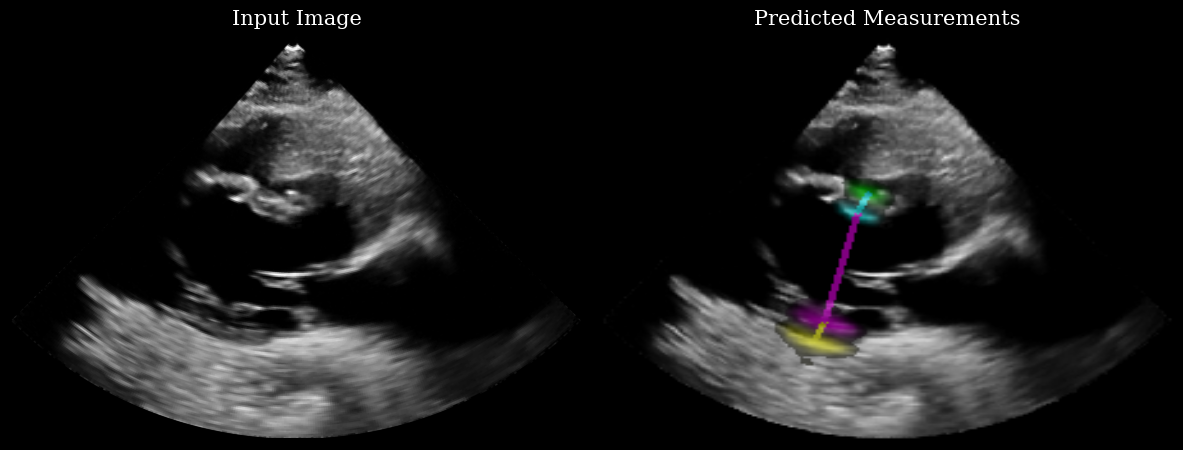

In [ ]:
from zea.models.echonetlvh import EchoNetLVH

# Load model from zeahub 
model = EchoNetLVH.from_preset("echonetlvh")

# Add batch + channel dims
batch = ops.convert_to_tensor(img_np[None, ..., None])

# apply model to image, producing logits
logits = model(batch)

# use visualization function to visualize heatmaps and measurement lines on the input image
images_with_measurements = model.visualize_logits(batch, logits)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot input image
ax1.imshow(img_np, cmap='gray')
ax1.set_title('Input Image', fontsize=15)
ax1.axis('off')

# Plot output with measurements
ax2.imshow(images_with_measurements[0])
ax2.set_title('Predicted Measurements', fontsize=15)
ax2.axis('off')

plt.tight_layout()
plt.show()

### Extracting the measurement points
The EchoNetLVH model ouptuts 4 heatmaps -- one for each key point. The heatmaps indicate the probability that each pixel contains the key point. Because of this, we need a function to extract the key point from a given heatmap. There are various ways to do this -- we implement a center-of-mass approach, preserving differentiability.

What we print below is the set of key points represented as indices with respect to the input image matrix.

In [8]:
key_points = ops.cast(model.extract_key_points_as_indices(logits)[0], "int")
measurement_keys = ['LVPW', 'LVID', 'IVS']
print("Measurement type: [H1, W1] -> [H2, W2]")
for i in range(3):
    print(f"{measurement_keys[i]}: {key_points[i]} -> {key_points[i+1]}")

Measurement type: [H1, W1] -> [H2, W2]
LVPW: [299 217] -> [287 226]
LVID: [287 226] -> [182 286]
IVS: [182 286] -> [187 281]
